# Machine Learning Homework 6

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mat4py import loadmat
from scipy.optimize import minimize
import ipdb as debugger

## Problem 1: Support Vector Machine

## Part A
a). For the regression support vector machine considered aboce, show that all training data points for which $\xi_n > 0$ will have $a_n = C$ and similarly all points for which $\hat{\xi}_n > 0$ will have $\hat{a}_n = C$ 

In SVM regression, the regularized error fufnction, using $\epsilon$-insensitive error function, is given by, 
\begin{equation}
C\sum_{n=1}^N E_\epsilon(y(\mathbf{x}_n) - t_n) + \frac{1}{2}||\mathbf{w}||^2
\end{equation}

After introducing the slack variables, the Lagrangian to be optimized is therefore, 
\begin{align}
L = &C\sum_{n=1}^N (\xi_n + \hat{\xi_n}) + \frac{1}{2}||\mathbf{w}||^2 - \sum_{n=1}^N(\mu_n\xi_n + \hat{\mu}_n\hat{\xi}_n) \\
&- \sum_{n=1}^N a_n(\epsilon + \xi_n + y_n - t_n) - \sum_{n=1}^N \hat{a}_n (\epsilon + \hat{\xi_n} - y_n + t_n)
\end{align}
Subject to $a_n \geq 0,\hat{a}_n \geq 0, \mu_n \geq 0$ and $\hat{\mu}_n \geq 0$

Therefore, under KKT conditions, we know that, 
\begin{align}
a_n (\epsilon + \xi_n + y_n - t_n) &= 0\\
\hat{a}_n (\epsilon + \hat{\xi}_n - y_n + t_n) &= 0\\
(C - a_n) \xi_n &= 0\\
(C - \hat{a}_n)\xi_n &= 0
\end{align}

From equation 3 and 4, we can see that $\xi_n > 0$ will have $a_n = C$ and $\hat{\xi}_n > 0$ will have $\hat{a}_n = C$ 


b). Compute the dual lagrangian for the support vector regression. 

If we take derivative of the lagrangian above with respect to $\mathbf{w}$, $b$, $\xi_n$ and $\hat{\xi}_n$ to zero, we have, 
\begin{align}
\frac{\partial L}{\partial \mathbf{w}} &= 0\ \to \ \mathbf{w} = \sum_{n=1}^N(a_n - \hat{a_n})\boldsymbol{\phi}(\mathbf{x}_n)\\
\frac{\partial L}{\partial b} &= 0 \ \to \ \sum_{n=1}^N(a_n - \hat{a}_n) = 0\\
\frac{\partial L}{\partial \xi_n} &= 0 \ \to \ a_n + \mu_n = C\\
\frac{\partial L}{\partial \hat{\xi}_n} &= 0 \ \to \ \hat{a}_n + \hat{\mu}_n = C
\end{align}

Using the relations obtained we can get a dual Lagrangian, which is, 
\begin{align}
\tilde{L}(\mathbf{a}, \hat{\mathbf{a}}) = &-\frac{1}{2}\sum_{n=1}^N \sum_{m=1}^N (a_n - \hat{a}_n)(a_m - \hat{a}_m)k(\mathbf{x}_n, \mathbf{x}_m)\\
&-\epsilon\sum_{n=1}^N(a_n + \hat{a}_n) + \sum_{n=1}^N(a_n - \hat{a}_n)t_n
\end{align}

### Part B
For the data-set given, train a support vector machine with polynomial kernel $p$. Perform for various polynomial orders and plot order vs. error. To ensure hard margin, use $C = 10^6$. 

The implementation of the SVM is described as such. The prediction model is obtained as, 
\begin{equation}
y(\mathbf{x}) = \sum_{n=1}^N (a_n - \hat{a}_n)k(\mathbf{x}, \mathbf{x}_n) + b
\end{equation}

where the constituents of the coefficients are determined by the results from Karush-Kuhn-Tucker condtiions, being, 
\begin{align}
a_n (\epsilon + \xi_n + y_n - t_n) &= 0\\
\hat{a}_n (\epsilon + \hat{\xi}_n - y_n + t_n) &= 0\\
(C - a_n) \xi_n &= 0\\
(C - \hat{a}_n)\xi_n &= 0
\end{align}

Here we obtain the solution through CG minimization on the dual lagrangian,
\begin{align}
\tilde{L}(\mathbf{a}, \hat{\mathbf{a}}) = &-\frac{1}{2}\sum_{n=1}^N \sum_{m=1}^N (a_n - \hat{a}_n)(a_m - \hat{a}_m)k(\mathbf{x}_n, \mathbf{x}_m)\\
&-\epsilon\sum_{n=1}^N(a_n + \hat{a}_n) + \sum_{n=1}^N(a_n - \hat{a}_n)t_n
\end{align}

subject the the box constraint, 
\begin{align}
0 \leq a_n \leq C&\\
0 \leq \hat{a}_n \leq C&
\end{align}

The bias $b$ can be obtained by, 
\begin{equation}
b = t_n - \epsilon - \sum_{m=1}^N(a_m - \hat{a}_m)k(\mathbf{x}_n, \mathbf{x}_m)
\end{equation}

In [4]:
# import data
p1_data = loadmat("Resources/P1/P1.mat")
print(p1_data.keys())

dict_keys(['test_data', 'test_label', 'train_data', 'train_label'])


In [5]:
test_data = np.array(p1_data['test_data'])
test_label = np.array(p1_data['test_label'])
train_data = np.array(p1_data['train_data'])
train_label = np.array(p1_data['train_label'])

In [6]:
train_data.shape

(30, 285)

In [7]:
train_label.shape

(285, 1)

In [8]:
D, N = train_data.shape

In [9]:
# define kernel function
def poly(xvec1, xvec2, c, m):
    '''
    Polynomial kernel containing all terms up to order m: 
    k(xvec1, xvec2) = (xvec1.T @ xvec2 + c)**M for c>0
    
    xvec1: D x 1 2D array
    xvec2: D x 1 2D array
    c    : float
    m    : int
    '''
    
    return (np.squeeze(xvec1.T @ xvec2) + c)**m

In [10]:
# define lagrangian and derivative of lagrangian
def L_tilde(A, *args):
    '''
    Dual Lagrangian for SVM regression. 
    
    A    : 2N 1D array, concatenation of a and a_hat. In this form to parse to scipy optimizer
    C    : float, inverse regularization parameter
    eps  : float, tube size for epsilon-insenstive error
    X    : DxN 2D array, training input data
    T    : Nx1 2D array, training label
    k    : function, kernel function (compatible with polynomial kernel here only)
    c_k  : float, kernel parameter
    m    : int, kernel parameter
    '''
    eps, X, T, K = args
    D,N = X.shape
    # unpack params
    a_nh = A[:N].reshape(N,1)
    a_hat = A[N:].reshape(N,1)
    
    # construct kernel matrix
    #debugger.set_trace()
    # compute L_tilde
    L = -0.5 * np.asscalar((a_nh-a_hat).T @ K @ (a_nh-a_hat)) - eps * np.sum(a_nh+a_hat) + np.sum((a_nh-a_hat) * T)
    #print(L)
    return L

In [11]:
# Initialise training
C = 1e6
eps = 0.1

bounds = [(0,C) for i in range(2*N)]

In [12]:
def K_matrix(data1, data2, m):
        '''
        data1: D x N1
        data2: D x N2
        kernel is poly only.
        '''
        N1 = data1.shape[1]
        N2 = data2.shape[1]
        
        return np.array([[poly(data1[:,n:n+1], data2[:,j:j+1], 1, m) for j in range(N2)] for n in range(N1)])
    
# Perform minimization on lagrangian
class SVM_reg(object):
    def __init__(self):
        pass
    
    def train(self, data, label, m, C=1e6, eps=0.1):
        self.data = data
        self.label = label
        D,N = data.shape
        A0 = np.random.random(2*N) * C
        K = K_matrix(data, data,m)
        #debugger.set_trace()
        res = minimize(L_tilde, A0, args=(eps, data, label, K), method='L-BFGS-B', bounds = bounds, tol=1e-8)
        A = res.x
        # correct constraint incompatibility
        A[A>0] = C
        self.m = m
        self.N = N
        self.eps = eps
        self.C = C
        self.a_nh = A[:N]
        self.a_hat = A[N:]
        self.b = label[0,0] - eps - (self.a_nh - self.a_hat).reshape(1,N) @ K[:,0]
        
    def predict(self, pred_data):
        '''Data should be in 2D array, D x N format'''
        K = K_matrix(pred_data, self.data, self.m)
        y = K @ (self.a_nh - self.a_hat).reshape(self.N, 1) + self.b # shape: N_pred x 1
        
        # Accidentally used regression for classification. Here an observation is made that large values
        # prediction is produced having the opposite signs of the target. So a custom filter is used to get
        # the result
        y = (y<0).astype(int)
        y[y==0] = -1
        
        return y
        

    def test(self, test_data, test_label):
        y = self.predict(test_data)
        # using eps-insensitive loss
        diff = y - test_label
        diff[diff < self.eps] = 0
        return np.mean(diff)

In [13]:
SVM_regressor = SVM_reg()
SVM_regressor.train(train_data, train_label,10)

In [14]:
err =SVM_regressor.test(test_data, test_label)

In [15]:
err

0.4

## Problem 2: Relevance vector machine
### Part A
a). For RVM discussed above, compute mean and covariance of hte posterior distribution over weights. 

The posterior distribution is computed as below, 

\begin{align}
p(\mathbf{w}|\mathbf{t}, \mathbf{X}, \mathbf{\alpha}, \mathbf{\beta}) &= p(\mathbf{t}|\mathbf{X},\mathbf{w},\beta^{-1})p(\mathbf{w}|\mathbf{\alpha})\\
&= \prod_{n=1}^N \mathcal{N}(t_n|\mathbf{w}^T\boldsymbol{\phi}(\mathbf{x}_n), \beta^{-1})\prod_{i=1}^M \mathcal{N}(w_i|0, \alpha_i^{-1})\\
&\propto \exp\{(\mathbf{w} - \beta\Sigma\boldsymbol{\Phi}^T\mathbf{t})^T\boldsymbol{\Sigma}^{-1}(\mathbf{w} - \beta\Sigma\boldsymbol{\Phi}^T\mathbf{t})\}
\end{align}

Therefore we obtain, 
\begin{align}
p(\mathbf{w}|\mathbf{t}, \mathbf{X}, \mathbf{\alpha}, \mathbf{\beta}) &= \mathcal{N}(\mathbf{w}|\mathbf{m},\boldsymbol{\Sigma})\\
\mathbf{m} &= \beta\boldsymbol{\Sigma}\boldsymbol{\Phi}^T\mathbf{t}\\
\boldsymbol{\Sigma} &= (\mathbf{A} + \beta\boldsymbol{\Phi}^T\boldsymbol{\Phi})^{-1}
\end{align}

b). Derive the results for the marginal likelihood function in the regression RVM, by performing the Gaussian integral over w in (7.84) using the technique of completing the square in the exponential. 

The marginal likelihood is 
\begin{align}
p(\mathbf{t}|\mathbf{X}, \mathbf{\alpha}, \mathbf{\beta}) &= \int p(\mathbf{t}|\mathbf{X},\mathbf{w},\beta^{-1})p(\mathbf{w}|\mathbf{\alpha})d\mathbf{w}\\
&= \int \prod_{n=1}^N \mathcal{N}(t_n|\mathbf{w}^T\boldsymbol{\phi}(\mathbf{x}_n), \beta^{-1})\prod_{i=1}^M \mathcal{N}(w_i|0, \alpha_i^{-1})d\mathbf{w}\\
\end{align}

c). Derive the re-estimation equations as discussed in the notes. 

### Part B
For the dataset provided, train a regression model by using RVM. Use
\begin{equation}
y(\mathbf{x}) = \sum_{i=1}^N w_n k(\mathbf{x}, \mathbf{x_n}) + b
\end{equation}
where $b$ is the bias parameter. Consider the kernel $k$ to be Gaussian with kernel width 5.5. Plot the predictions along with proper prediction bounds. 

In [16]:
# load p2 data
p2_data = loadmat('Resources/P2/P2.mat')
print(p2_data.keys())

dict_keys(['X', 'Xtest', 'Y', 'Ytest'])


In [17]:
X = np.array(p2_data['X'])
Xtest = np.array(p2_data['Xtest'])
Y = np.array(p2_data['Y'])
Ytest = np.array(p2_data['Ytest'])

In [18]:
print(X.shape)
print(Xtest.shape)
print(Y.shape)
print(Ytest.shape)

(100, 1)
(20, 1)
(100, 1)
(20, 1)


In [27]:
def kgauss(x1,x2):
    
    sigma2=5.5
    # x1 and x2 are 1d arrays
    enorm = np.sqrt(np.sum((x1-x2)**2))  
    return np.exp(-enorm/2*sigma2)

In [126]:
def Phi_matrix(data1, data2):
        '''
        data1: N1 x 1
        data2: N2 x 1
        kernel is poly only.
        '''
        N1 = data1.shape[0]
        N2 = data2.shape[0]
        
        return np.array([[kgauss(data1[i,0], data2[j,0]) for j in range(N2)] for i in range(N1)])
# Training: 1. Get MLE for alpha and beta 2. Update the effective weights
class RVM(object):
    def __init__(self):
        pass
    
    def train(self, train, label):
        '''Data shape: Nx1'''
        N = train.shape[0]
        
        # construct kernel
        Phi = Phi_matrix(train, train)
        
        # Initialise alpha and beta
        alpha = np.random.randn(X.shape[0])
        beta = 1
        
        # initialize other parameters
        A = np.diag(alpha)
        Sigma = np.linalg.inv(A + beta * Phi.T @ Phi)
        m = beta * Sigma @ Phi.T @ label
        
        
        # Use re-estimation equations to obtain MLE solution
        tol = 1e-6
        err_record = []
        counter = 0
        while True:
            gamma = 1 - alpha * np.diag(Sigma)
            alpha_new = gamma / (m.reshape(N))**2
            beta_new = (N - np.sum(gamma))/np.linalg.norm(label - Phi @ m)
            
            
            # test convergence
            A = np.diag(alpha_new)
            Sigma_new = np.linalg.inv(A + beta_new * Phi.T @ Phi)
            m_new = beta_new * Sigma_new @ Phi.T @ label
            
            err = max(abs(m_new - m))
            err_record.append(err)
            if err < tol:
                print("Training complete")
                break
            elif counter > 4000:
                print("MaxIter exceeded.Final err: {}".format(err))
                break
            else:
                alpha[:] = alpha_new[:]
                beta = beta_new
                Sigma[:,:] = Sigma_new[:,:]
                m[:,:] = m_new[:,:]
                
                counter += 1
        
        self.err_record = err_record
        self.alpha = alpha
        self.beta = beta
        self.Sigma = Sigma
        self.w = m
        self.Xtrain = train
        self.Ytrain = label
        self.b = np.mean(label - Phi @ m)
    
    def pred(self, test):
        
        # construct Phi matrix
        Phi = Phi_matrix(test, self.Xtrain)
        self.Ypred = Phi @ self.w
        #debugger.set_trace()
        self.Ystd = np.diag((1/self.beta + Phi @ self.Sigma @ Phi.T)**0.5)
        

In [127]:
rvm = RVM()
rvm.train(X,Y)

MaxIter exceeded.Final err: [0.01423674]


In [128]:
x = np.arange(-10,10,0.1)
rvm.pred(x[:,np.newaxis])
ypred = np.squeeze(rvm.Ypred)
ystd = np.squeeze(rvm.Ystd)


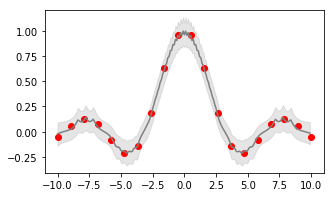

In [130]:
fig, ax= plt.subplots(figsize=(5,3))
ax.plot(Xtest, Ytest, 'or')
ax.plot(x, ypred, '-', color='gray')

ax.fill_between(x, ypred - 2*ystd, ypred + 2*ystd,
                 color='gray', alpha=0.2)

plt.show()

## Problem 3: Gaussian process
### Part A
Learn the values of $\theta_{1-3}$ by MLE based on the training points. The log-likelihood is known to be non-convex, so try several starting points for optimization to see if that affects the results. 

In [131]:
X = np.array([1.71, 2.33, 4.33, 4.84, 4.86, 5.54]).reshape(6,1)
Y = np.array([-0.2138, 1.0389, 0.7630, 0.2271, 0.2733, 1.0565]).reshape(6,1)

In [132]:
# define kernel
def k(x,xp, t1, t2, t3):
    return t1 * np.exp(-(x-xp)**2/(2*t2)) + t3 * float(x==xp)

# define derivatives
def dkdt1(x,xp,t1,t2,t3):
    return np.exp(-(x-xp)**2/(2*t2))

def dkdt2(x,xp,t1,t2,t3):
    return t1/(2*t2**2) * (x-xp)**2 * np.exp(-(x-xp)**2/(2*t2))

def dkdt3(x,xp,t1,t2,t3):
    return float(x==xp)


In [133]:
# define derivative of NLL
def dNLL(Y,X, t1, t2, t3):
    Ky = np.array([[k(X[i,0],X[j,0],t1,t2,t3) for i in range(6)] for j in range(6)])
    dKdt1 = np.array([[dkdt1(X[i,0],X[j,0],t1,t2,t3) for i in range(6)] for j in range(6)])
    dKdt2 = np.array([[dkdt2(X[i,0],X[j,0],t1,t2,t3) for i in range(6)] for j in range(6)])
    dKdt3 = np.array([[dkdt3(X[i,0],X[j,0],t1,t2,t3) for i in range(6)] for j in range(6)])
    
    Ky_inv = np.linalg.inv(Ky)
    alpha = Ky_inv @ Y
    
    A = (alpha @ alpha.T) - Ky_inv
    dNlldt1 = 0.5 * np.trace(A @ dKdt1)
    dNlldt2 = 0.5 * np.trace(A @ dKdt2)
    dNlldt3 = 0.5 * np.trace(A @ dKdt3)
    
    return dNlldt1, dNlldt2, dNlldt3

In [134]:
# initialise t1-3
t1 = 1
t2 = 1
t3 = 1

def cg(t1,t2,t3, lam=0.001, tol=1e-3):
    err_record = []
    while True:
        dNlldt1, dNlldt2, dNlldt3 = dNLL(Y,X,t1,t2,t3)
        dt1 = lam * dNlldt1
        dt2 = lam * dNlldt2
        dt3 = lam * dNlldt3
        err = max(abs(np.array([dt1, dt2, dt3])))
        err_record.append(err)
        

        if err < tol:
            return t1, t2, t3, err_record
            break
        
        elif np.isnan(err) == True:
            print("Nan returned")
            break

        else:
            t1 = t1 - dt1
            t2 = t2 - dt2
            t3 = t3 - dt3
    

1 1 0.2


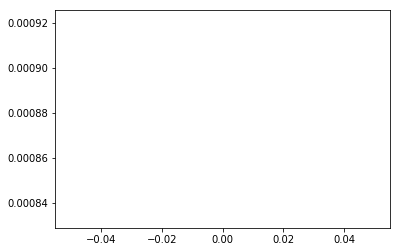

In [135]:
t11, t21, t31, record = cg(1,1,0.2, lam=0.001, tol=1e-3)
print(t11,t21,t31)
plt.plot(record)

1.0028329391361783 0.09794010354983883 0.0518160922218951


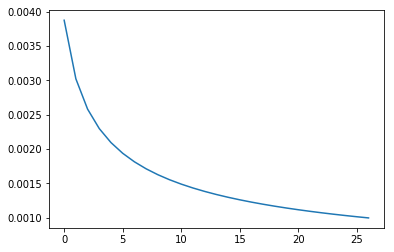

In [136]:
t12, t22, t32, record = cg(1,0.1,0.01, lam=0.0001, tol=1e-3)
print(t12,t22,t32)
plt.plot(record)

3.175780904548586 1.0236993123742404 1.4249431067146867


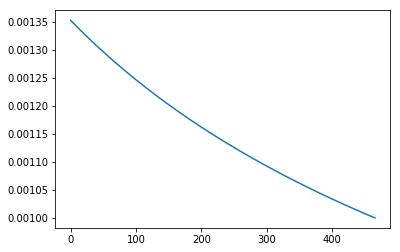

In [137]:
t13, t23, t33, record = cg(3.0,1.16,0.89, lam=0.001, tol=1e-3)
print(t13,t23,t33)
plt.plot(record)

### Part B
Run your Gaussian process with the learn parameters to predict for the testing points on the interval $x^* \in [1,6]$. Plot the prediction mean as well as the 95% condidence interval (two-sigma) of the learnt Gaussian process, and comapre with their exact values computed by the formula: $y = 2x$. Comment on the prediction performance

In [138]:
x = np.arange(1,6,0.1)
x = x[:,np.newaxis]
y_true = x*2

In [139]:
def gp_pred(Xtrain,Ytrain, Xpred, t1, t2, t3):
    Ky = np.array([[k(Xtrain[i,0],Xtrain[j,0],t1,t2,t3) for i in range(6)] for j in range(6)])
    Ks = np.array([[k(Xpred[i,0],Xtrain[j,0],t1,t2,t3) for i in range(Xpred.shape[0])] for j in range(6)])
    Kss = np.array([[k(Xpred[i,0],Xpred[j,0],t1,t2,t3) for j in range(Xpred.shape[0])] for i in range(Xpred.shape[0])])
    Ymean = np.squeeze(Ks.T @ np.linalg.inv(Ky) @ Ytrain)
    Ystd = np.sqrt(np.diag(Kss - Ks.T @ np.linalg.inv(Ky) @ Ks))
    
    return Ymean, Ystd

In [140]:
Ymean1, Ystd1 = gp_pred(X,Y, x, t11,t21,t31)
Ymean2, Ystd2 = gp_pred(X,Y, x, t12,t22,t32)
Ymean3, Ystd3 = gp_pred(X,Y, x, t13,t23,t33)

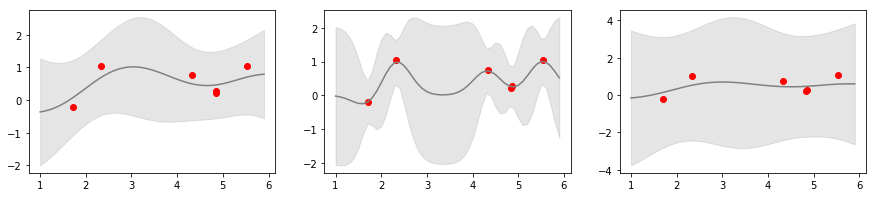

In [141]:
fig, axes = plt.subplots(ncols=3, figsize=(15,3))
axes[0].plot(X, Y, 'or')
axes[0].plot(x, Ymean1, '-', color='gray')

axes[0].fill_between(x[:,0], Ymean1 - 2*Ystd1, Ymean1 + 2*Ystd1,
                 color='gray', alpha=0.2)

axes[1].plot(X, Y, 'or')
axes[1].plot(x, Ymean2, '-', color='gray')

axes[1].fill_between(x[:,0], Ymean2 - 2*Ystd2, Ymean2 + 2*Ystd2,
                 color='gray', alpha=0.2)

axes[2].plot(X, Y, 'or')
axes[2].plot(x, Ymean3, '-', color='gray')

axes[2].fill_between(x[:,0], Ymean3 - 2*Ystd3, Ymean3 + 2*Ystd3,
                 color='gray', alpha=0.2)

plt.show()
#axes[0].set_xlim(0, 10);

## Problem 4: Gaussian process latent variable model
### Part A
a). Provide an expression for the likelihood of the data. Assume, the GPs to be independent across the features

Indepedence among features implies that the priors have diagonal covariances. Therefore, the corresponding likelihood is 
\begin{align}
p(\mathbf{Y}|\mathbf{X}, \sigma^2) &= \prod_{d=1}^D\mathcal{N}(\mathbf{y}_{:,d}|\mathbf{0}, \mathbf{X}\mathbf{X}^T + \sigma^2\mathbf{I})\\
&= (2\pi)^{-DN/2}|\mathbf{K}_z|^{-D/2}\exp(-\frac{1}{2}\text{tr}(\mathbf{K}_z^{-1}\mathbf{Y}\mathbf{Y}^T))
\end{align}
where, 
\begin{equation}
\mathbf{K}_z = \mathbf{X}\mathbf{X}^T + \sigma^2\mathbf{I}
\end{equation}

b). The marginal distribution of this form is intractable because that the conditional probability cannot be represented without integrating out the weights which transforms from latent space to the observation space, which again requires a prior on the weights. 

c). Provide a variational approximation for the marginal distribution. 

Not sure how to do this. 

### Part B
For the oil data, use GPLVM to identify the latent dimensions. Onsider latent dimensions to be 3. Show the three latent dimensions. 

In [115]:
dataTrain = np.array(loadmat("Resources/P4/DataTrn.mat")['DataTrn'])
dataTest = np.array(loadmat("Resources/P4/DataTst.mat")['DataTst'])
dataTrainLbls = np.array(loadmat("Resources/P4/DataTrnLbls.mat")['DataTrnLbls'])
dataTestLbls = np.array(loadmat("Resources/P4/DataTstLbls.mat")['DataTstLbls'])

In [116]:
print(dataTrain.shape)
print(dataTest.shape)
print(dataTrainLbls.shape)
print(dataTestLbls.shape)

(1000, 12)
(1000, 12)
(1000, 3)
(1000, 3)


In [163]:
# Dimension for latent space
D = 3
N = dataTrain.shape[0]
t1 = 1
t2 = 0.1
t3 = 0.05

# kernel for latent space
# define kernel
def k(x,xp, t1=t1, t2=t2, t3=t3):
    return t1 * np.exp(-np.sum((x-xp)**2)/(2*t2)) # + t3 * float(max(abs(x - xp)) == 0)

In [164]:
def error(Z, labels):
    return np.mean(np.abs((Z - labels)))

def lGPLVM(Z, Y, sigma2, D, k, labels, t1=t1, t2=t2, t3=t3):
    '''To use in the standard optimizer, Z is parsed as 3N array'''
    global nll_global
    N = Y.shape[0]
    Z = Z.reshape(N,D)
    Kz = np.array([[k(Z[i,:],Z[j,:]) for i in range(N)] for j in range(N)]) + np.eye(N) * sigma2
    nll = D/2 * np.log(np.linalg.norm(Kz)) + 0.5 * np.trace(np.linalg.inv(Kz) @ Y @ Y.T) - D * N /2 * np.log(2*np.pi)
    nll = nll / N
    nll_global = nll
    # print current error
    return nll

def dldZij(Z, Y, sigma2, D, k, labels, t1=t1, t2=t2, t3=t3):
    N = Y.shape[0]
    Z = Z.reshape(N,D)
    Kz = np.array([[k(Z[i,:],Z[j,:]) for i in range(N)] for j in range(N)]) + np.eye(N) * sigma2
    Kz_inv = np.linalg.inv(Kz)
    
    dldKz = -Kz_inv @ Y @ Y.T @ Kz_inv + D * Kz_inv
    
    dldZ = np.zeros(Z.shape)
    for i in range(N):
        for j in range(D):
            dKdZij = np.zeros(Kz.shape)
            dKdZij[i,:] = (Z[:,j] - Z[i,j])/t2 * Kz[i,:]
            dKdZij[:,i] = (Z[:,j] - Z[i,j])/t2 * Kz[:,i]
            dldZ[i,j] = 0
            dldZ[i,j] = np.sum(dldKz * dKdZij)
    return dldZ.reshape(3*N) / N

In [165]:
global counter, Z_record, nll_global
counter = 0
sigma2 = 0.5
Z = np.random.randn(3*N)
Z_record = []

In [166]:
def reporter(zk):
    global Z_record, counter, nll_global
    print("Iteration {}: Current nll = {:7.6f}.".format(counter, nll_global))
    counter += 1
    Z_record.append(zk)

In [ ]:
res = minimize(lGPLVM, 
               Z, 
               args=(dataTrain, sigma2, D, k, dataTrainLbls, t1, t2, t3), 
               method='CG',
               jac=dldZij, 
               tol=1e-4, 
               options={'maxiter':100, 'disp':True},
               callback=reporter)
A = res.x

In [168]:
Zpred = Z_record[-1].reshape(N,D)

In [169]:
ZtrainMark = np.argmax(dataTrainLbls, axis=1)

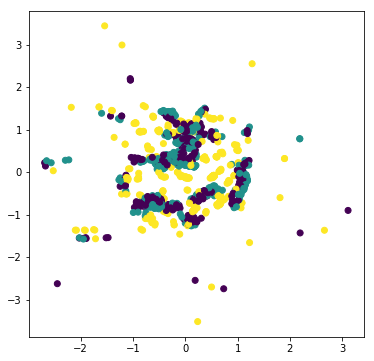

In [172]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(Zpred[:,0], Zpred[:,1], c=ZtrainMark)
plt.show()

Sorry this is as far as I can go here..Somehow I am not able to obtain the correct latent space values. 